# *In silico* Bayesian optimization with Odyssey

We are now moving away from the local optimizer and use the *real world* Bayesian optimizer in a similar way that you used the SciPy optimizers in `02_Color_Mixing_and_Optimization_InSilico.ipynb`. 

You will be using [**Odyssey**](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/), Python-based Bayesian optimization framework developed internally at DTU. You will move on to the PumpBot in the next exercise, so make sure you do proper coding and experiment with parameters in this exercise to make the next one easier. 

You have already gotten a good taste of coding your own Bayesian optimizer in the `04_Bayesian_Optimization_Tutorial.ipynb`, 
but you are generally better off using one of the readily available Bayesian optimizers unless you have something 
very specific in mind. Many of these are built on top of [BoTorch](https://botorch.org/), a very popular Bayesian optimization library in Python.

Please take some time to read the [Structure of Odyssey](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/getting-started/structure/) to have an overview its design.

Let's start by importing `Odyssey` and some additional packages.

In [6]:
# Odyssey 
from odyssey.mission import Mission # Mission
from odyssey.objective import Objective # Objective
from odyssey.navigators import SingleGP_Navigator # Navigator
from odyssey.navigators.sampler_navigators import Sobol_Navigator, Grid_Navigator # Sampler
from odyssey.navigators import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound, LogExpectedImprovement, LogProbabilityOfImprovement # Acquisition functions

# Other Packages
import torch
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from IPython import display
from warnings import catch_warnings, simplefilter

You can see that seeral classes are imported, including `Mission`, `Objective`, `SingleGP_Navigator`, `Sobol_Navigator`, `Grid_Navigator`, and the acquisition functions `ExpectedImprovement`, `LogEI`, `ProbabilityOfImprovement`, `UpperConfidenceBound`, `LogExpectedImprovement`, and `LogProbabilityOfImprovement`. You should read more about these here:

- [Mission](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/mission/)
- [Objective](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/objective/#odyssey.objective.Objective)
- Single Objective Navigator:
    - [SingleGP_Navigator](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/navigators/#odyssey.navigators.SingleGP_Navigator)
- Sampler Navigator:
    - [Sobol Sampler Navigator](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/navigators/#odyssey.navigators.sampler_navigators.Sobol_Navigator)
- [Acquisition Functions](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/api_reference/acquisition_functions/)

## Exercise 1: Optimization of Single-Input-Single-Output (SISO) function

Let's start with a (very) simple example of finding the global minimum of the function below for $x \in [-5, 5]$.

In [7]:
def simple_function(x):
    val = x ** 4 - 10 * x**2 + 5 * x
    return val/100

Let's visualize the `simple_function` to see where the minimum values are.

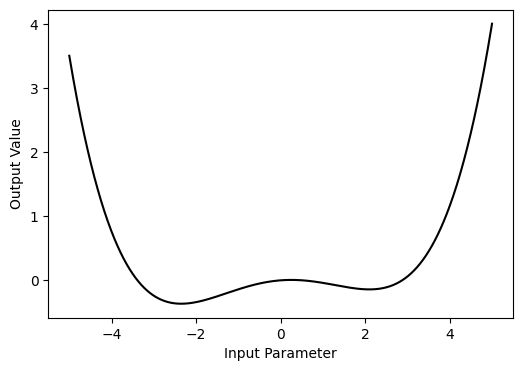

In [8]:
test_X = torch.linspace(-5, 5, 1000)
test_Y = simple_function(test_X)

plt.figure(figsize=(6, 4))
plt.plot(test_X, test_Y, color='black')
plt.xlabel('Input Parameter')
plt.ylabel('Output Value')
plt.show()

You can see that there are two local minima: $x \approx -2.35$ and $x \approx +2.1$. The first one is the global minimum. 

We now proceed to find the global minimum using Odyssey. We start our "mission" (also often called campaign) using Odyssey's `Mission` class, which takes several attributes.  

```python
mission = Misson(name='Name of your mission',
                 funcs=[],
                 maneuvers=goals,
                 envelope=param_space)
```

The `funcs` is a list of objective functions, while `manuevers` is a list of goals, which can be either ascend (i.e., finding global maximum) or descend (i.e., finding global minimum). We start by creating an objective function for Odyssey using our `simple_function`.

In [9]:
objective = Objective(func=simple_function)

Next up, we initialize our mission. Note that `func` and `maneuvers` are list of length one for a single-objective optimization. The lengths of these attributes are longer for the multi-objective cases. 

In [10]:
mission = Mission(name="Minimizing a simple function",
                  funcs=[objective],
                  maneuvers=['descend'],
                  envelope=[(-5.0, 5.0)])

We have now defined our mission by specifying our objective function, whether we would like to find a maximum/minimum, and the boundaries of the domain we would like to explore. The next step is to specify how we would like to navigate through our search space, and we achieve this using `Navigator`. 

We use `SingleGP_Navigator` for single-objective Bayesian optimization, which employs a single Gaussian Process (GP) model to approximate the objective function and guide the search for the optimal solution using an acquisition function. The first step of the optimization sequence to explore a fixed set of initial data points before using the acquisition function. Let's explore 3 initial points, which is selected in a uniform fashion by dividing our search space into grids. Once the initial points are explored, we will continue the optimization by using `ExpectedImprovement` as an acquisition function. 

In [11]:
num_init_points = 3
navigator = SingleGP_Navigator(mission=mission,
                               num_init_design=num_init_points,
                               input_scaling=False,
                               data_standardization=False,
                               init_method=Grid_Navigator(mission=mission, subdivisions=num_init_points),
                               acq_function_type=ExpectedImprovement,
                               acq_function_params={'best_f': 0.0}
)

tensor([[5.]])
tensor([[-5.]])
tensor([[0.]])
Succesfully appended {'param_1': [5.0, -5.0, 0.0], 'objective_1': [4.0, 3.5, 0.0], 'creation_timestamp': '26-05-25 23:48:44'} to missionlogs/Minimizing a simple function-260525_234844.csv


/Users/achtu/Library/Caches/pypoetry/virtualenvs/colorbot2--_9kUS4P-py3.12/lib/python3.12/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Although it was not so obvious, initantiating the navigator above has already selected 3 points and evaluated the objective function. You can see that by plotting the objective function and the observed points. Since we can use these functionalities multiple times, let's make them into functions.

In [27]:
def calculate_posterior():
    model = navigator.model
    pred_mean = -model.posterior(test_X).mean.detach().squeeze()
    pred_std = torch.sqrt(model.posterior(test_X).variance).detach().squeeze()
    return (pred_mean, pred_std)

In [28]:
def plot_progres():
    fig, ax = plt.subplots(figsize=(10, 6))
    pred_mean, pred_std = calculate_posterior()
    # Real function
    ax.plot(test_X, test_Y, color='red', label='Real Function')
    # Measurements
    ax.scatter(mission.display_X, mission.display_Y, color = 'k', marker = '.', label='Measurements')
    # Posterior model and uncertainty
    ax.plot(test_X.squeeze(), pred_mean, color = 'g', linestyle = 'dashed', label = 'Posterior Model')
    ax.fill_between(test_X.squeeze(), pred_mean - 2*pred_std, pred_mean + 2*pred_std, color  ='g', alpha = 0.3, label = 'Posterior Uncertainty')

    ax.set_xlabel('Input Parameter')
    ax.set_ylabel('Output Value')
    ax.title.set_text(f'Iteration: {len(mission.train_X) - num_init_points}, new x = {trajectory.item():.3f}, y = {observation.item():.3f}')
    ax.legend()

    plt.show()

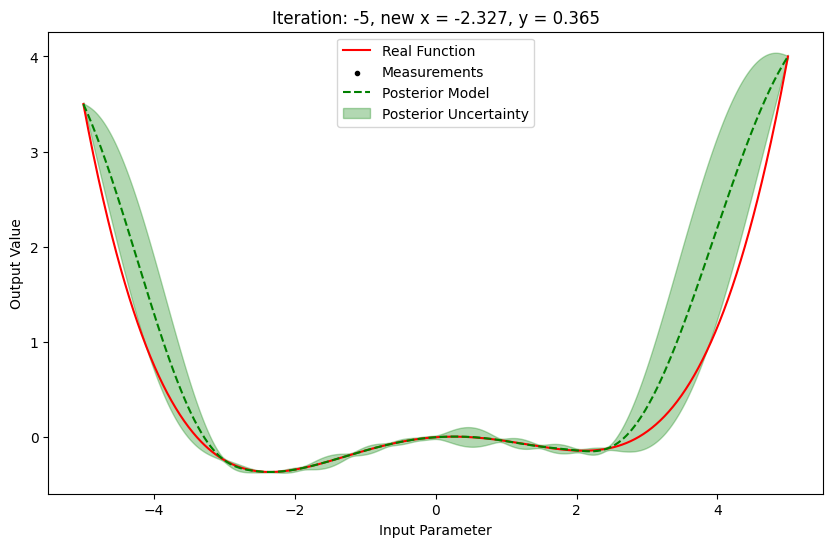

In [ ]:
num_iter = 10

from warnings import catch_warnings
from warnings import simplefilter

while len(mission.train_X) - num_init_points < num_iter:
    with catch_warnings() as w:
        simplefilter('ignore')
        trajectory = navigator.trajectory()
        observation = navigator.probe(trajectory, init = False)
        navigator.relay(trajectory, observation)
        navigator.upgrade()
        
        display.clear_output(wait=True) # This will help you remove figures as you go
        plot_progres()
        input('Press Enter to proceed.')

You are **strongly** encouraged to experiment with different acquisition functions and parameters, including the `num_iter` value to see how the optimization progresses if you let it run longer. Once you are done with the optimization, you can run the cell below to see what is the best observed point is. 

In [ ]:
best_idx = mission.display_Y.argmin().item()
best_input = mission.display_X[best_idx].item()
best_output = mission.display_Y[best_idx].item()

print(f'Best Input: {best_input}')
print(f'Best Output: {best_output}')

Best Input: -2.4044812594133615
Best Output: -0.36411616957861276


## Exercise 2: Single-Input-Single-Output (SISO) function with noise

You have completed the most basic optimization. Let's make this a bit more challenging by adding some noise. Please read through the example from the Odyssey documentation [here](https://odyssey-auto-lab-de98adb48801ec6a9ad6d1738d8ce68e811b24234385b9.gitlab.io/examples/single-objective-optimization/) and run it yourself in the cells below. 

Feel free to add more cells as you need.

In [16]:
# place for your code

In [17]:
# place for your code

In [18]:
# place for your code

In [19]:
# place for your code

## Exercise 3: Moving on to the color mixing

You have learned what you need to know about Odyssey! It is time to get back to the color mixing. 

As usual, we use `SilicoPumpController` of pump_controller module to simulate the color mixing. In case you have forgotten, you can read more about the different classes and methods in the pump_controller module [here](https://www.student.dtu.dk/~s193903/47332/).

Reusing your code from the first *in silico* exercise, figure out how to mix the taget color below using Odyssey.

You will use this code on the pumpbot tomorrow, so be thorough and make sure to include breakpoints during the function calls. Plotting progress using `visualize_candidates()` function will be very helpful in understanding how the optimization is progressing and whether or no you are satisfied with the results. 

In [20]:
# Pump Controller
from pump_controller import SilicoPumpController, visualize_rgb, visualize_candidates, read_logfile

In [21]:
target_color = [164., 176., 84.]

In [22]:
# Let's have some noise to keep it real.
silicobot = SilicoPumpController(noise_std = 3)

In [ ]:
# function for getting the color difference
def color_difference(mixed_color, target_color):
    # your code goes here
    r1, g1, b1 = input_color1[0], input_color1[1], input_color1[2]
    r2, g2, b2 = input_color2[0], input_color2[1], input_color2[2]
    sq_sum = (r1 - r2)**2 + (g1 - g2)**2 + (b1 - b2)**2
    return np.sqrt(sq_sum)

In [ ]:
# This is going to be your objective function
def find_score_from_color(mixture):
    # take the mixture [R, G, B, Y] and return the score. 
    measured_color = silicobot.mix_color(mixture)
    score = color_difference(measured_color, silicobot.target_color)
    return score


In [25]:
silicobot.target_color = target_color

In [ ]:
objective = Objective(func=find_score_from_color)

mission = Mission(name="in silico color mixer",
                  funcs=[objective],
                  maneuvers=['descend'],
                  envelope=[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)])

num_init_points = 5

navigator = SingleGP_Navigator(mission=mission,
                               num_init_design=num_init_points,
                               input_scaling=False,
                               data_standardization=False,
                               init_method=Grid_Navigator(mission=mission, subdivisions=num_init_points),
                               acq_function_type=ProbabilityOfImprovement,
                               acq_function_params={'best_f': 0.0}
)

tensor([[0.0000, 0.2500, 0.7500, 0.7500]])
tensor([[0.5000, 0.5000, 0.2500, 0.0000]])
tensor([[0.2500, 0.0000, 1.0000, 0.5000]])
tensor([[0.7500, 0.7500, 0.5000, 1.0000]])
tensor([[1.0000, 1.0000, 0.0000, 0.2500]])


NameError: name 'input_color1' is not defined

In [ ]:
logs = read_logfile(silicobot.log_file)
logs

In [ ]:
logs['score'] = [color_difference(logs['measurement'][i], logs['target_measurement'][i]) for i in range(len(logs))]
visualize_candidates(logs)

In [ ]:
num_iter = 100
while len(mission.train_X) - num_init_points < num_iter:

    with catch_warnings() as w:
        simplefilter('ignore')
        
        trajectory = navigator.trajectory()
        observation = navigator.probe(trajectory, init = False)

        navigator.relay(trajectory, observation)
        navigator.upgrade()

        logs = read_logfile(silicobot.log_file)
        logs['score'] = [color_difference(logs['measurement'][i], logs['target_measurement'][i]) for i in range(len(logs))]

        display.clear_output(wait=True)
        visualize_candidates(logs)

In [ ]:
best_idx = logs.score.argmin()

best_score = logs.score[best_idx]
best_mixture = logs.mixture[best_idx]
best_color = logs.measurement[best_idx]

print(f"Score {best_score} at mixture {best_mixture} with color {best_color}")

In [ ]:
# place for your code

In [ ]:
# place for your code

In [ ]:
# place for your code

In [ ]:
# place for your code.  Add more as needed.

In [ ]:
visualize_rgb(mixture = best_mixture,
              rgb = best_color,
              pump_controller = silicobot,
              target = silicobot.target_color,
              score = best_score
              )

When you are done, find the best observed point and plot its composition and color, taget color, and score using `visualize_rgb()` function.

# Re-using the old data

One thing is being able to reuse data generated with Dragonfly. Another thing is using data generated by other means. I have written a small helper function for you to help you with this. It is on purpose semi-manual to allow you to see what is going on. Let us go back to the 2D case to try it out.

In [ ]:
from legobot import make_dragonfly_save_file

Let us get some data. Normally you will not generate it but pull it out of a file.

In [ ]:
simple_function2D([2., 0.2])
simple_function2D([1., -0.2])
simple_function2D([-5., -1.])
simple_function2D([5., 1.])
simple_function2D([0., 0.])

Let us make that data into a list with the below format.

In [ ]:
data_list = [[2.0, 0.2, 12.239999999999998],
             [1.0, -0.2, 0.14],
             [-5.0, -1.0, 600.5],
             [5.0, 1.0, 601.5],
             [0.0, 0.0, 0.0]]

Dragonfly works in values relative to the bounds when saving data so we have to supply those as well. It also means that you should not use old savefiles when changing bounds, but you can always generate new savefiles from the raw results following the producere we examine here.

In [ ]:
constraints = [[-5., 5.], [-1., 1.]]

Lets make the file with data. 

In [ ]:
# The two top line finds your home directory
from pathlib import Path
home = str(Path.home())

filename = 'manual_data_simple_function2D'
file_path = home + '/47332/data/'
full_path = file_path + filename

make_dragonfly_save_file(data_list, full_path, constraints,)

Verify that you have written the file by looking at files in your data folder.

In [ ]:
!ls ~/47332/data/

Next, try using the file by loading it in.

In [ ]:
# The two top line finds your home directory
from pathlib import Path
home = str(Path.home())

options = Namespace(init_capital=9, build_new_model_every=9, report_results_every=9,
                    progress_load_from_and_save_to=home + '/47332/data/manual_data_simple_function2D', progress_save_every=3)

In [ ]:
max_func_calls = 5

min_val, min_x_list, history = minimize_function(simple_function2D, constraints, max_func_calls, options=options)
print(f'{min_x_list=}', f'{min_val=}')

When you do this trick (or load in data into Dragonfly in general), the initialization phase will be skipped. You should thus make sure that the data you load in is sufficiently diverse.

If you want practice and save time tomorrow, you can try this out with the SilicoColorMixer in the cells below.

In [ ]:
# place for your code

In [ ]:
# place for your code

In [ ]:
# place for your code

In [ ]:
# place for your code

This concludes todays notebook.